In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-darkgrid')

from theano import tensor as tt
from scipy import stats

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Chapter 11 - Signal detection theory
  
The basic data for an SDT analysis are  the counts of hits, false alarms, misses, and correct rejections. It is common to consider just the hit and false alarm counts which, together with the total number of signal and noise trials, completely describe the data.

|                  |   Signal trial   |   Noise trial    |
|:----------------:|:----------------:|:----------------:|
| Yes response     |        Hit       |   False alarm    |
| No response      |       Miss       |Correct rejection | 

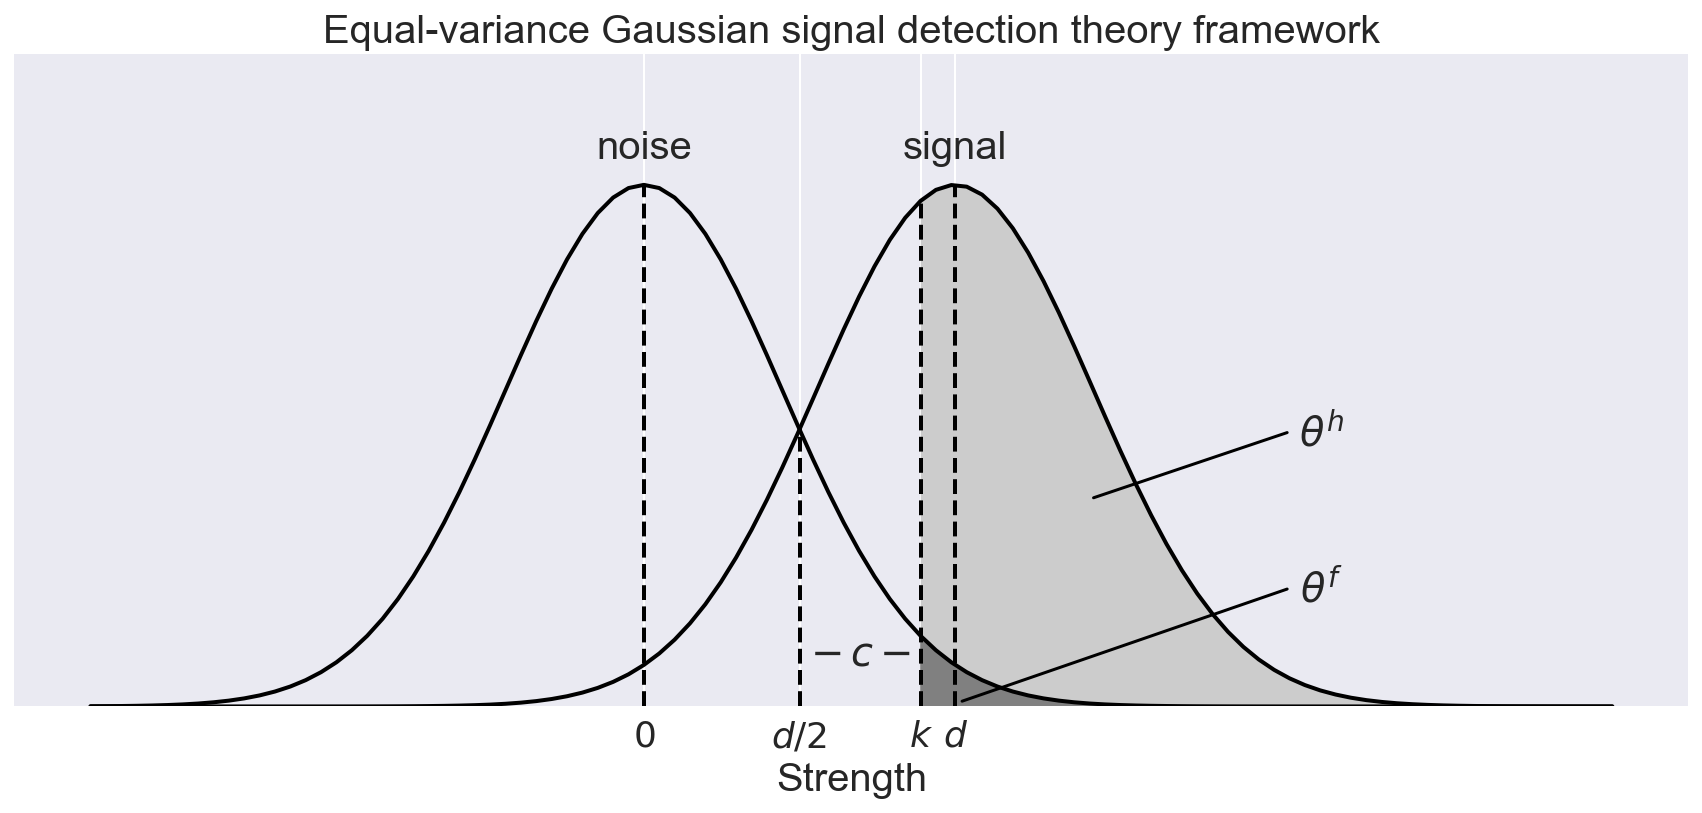

In [2]:
from matplotlib.patches import Polygon

func = stats.norm.pdf

a, b, d = 2, 7, 2.25  # integral limits 1
x = np.linspace(-4, b, 100)
y = func(x)
y2 = func(x, loc=d)

fig, ax = plt.subplots(figsize=(15, 6))

plt.plot(x, y, 'k', linewidth=2)
plt.plot(x, y2, 'k', linewidth=2)
d2 = x[y==y2]

# Make the shaded region
ix = np.linspace(a, b)
iy = func(ix)
iy2 = func(ix, loc=d)

verts = [(a, 0)] + list(zip(ix, iy2)) + [(b, 0)]
poly = Polygon(verts, facecolor='.8', edgecolor='1')
ax.add_patch(poly)

verts = [(a, 0)] + list(zip(ix, iy)) + [(b, 0)]
poly = Polygon(verts, facecolor='.5', edgecolor='0.5')
ax.add_patch(poly)

plt.text(0, y.max()+.02, "noise",
         horizontalalignment='center', fontsize=20)
plt.text(d, y.max()+.02, "signal",
         horizontalalignment='center', fontsize=20)
plt.text((d/2+a)/2, y.max()*.08, r"$ - \,c - $",
         horizontalalignment='center', fontsize=20)
plt.text(b*.7, y.max()*.5, r"$\theta^h$",
         horizontalalignment='center', fontsize=20)
plt.text(b*.7, y.max()*.2, r"$\theta^f$",
         horizontalalignment='center', fontsize=20)
plt.plot([d+1, b*.7-.25], [y.max()*.4, y.max()*.5+.01], color='k', linestyle='-', linewidth=1.5)
plt.plot([d+.05, b*.7-.25], [y.max()*.01, y.max()*.2+.01], color='k', linestyle='-', linewidth=1.5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

plt.plot([0, 0], [0, func(0)], color='k', linestyle='--', linewidth=2)
plt.plot([d/2, d/2], [0, func(d/2)], color='k', linestyle='--', linewidth=2)
plt.plot([a, a], [0, func(a, loc=d)], color='k', linestyle='--', linewidth=2)
plt.plot([d, d], [0, func(d, loc=d)], color='k', linestyle='--', linewidth=2)

ax.set_xticks((0, a, d, d/2))
ax.set_xticklabels(('$0$', '$k$', '$d$', '$d/2$'), fontsize=18)
ax.set_yticks([])
plt.ylim(0, y.max()+.1)
plt.title('Equal-variance Gaussian signal detection theory framework', fontsize=20)
plt.xlabel('Strength', fontsize=20)
plt.show()

## 11.1 Signal detection theory


$$ d_{i} \sim \text{Gaussian}(0,\frac{1}{2})$$
$$ c_{i} \sim \text{Gaussian}(0,2)$$
$$ \theta_{i}^h = \Phi(\frac{1}{2}d_{i}-c_{i})$$
$$ \theta_{i}^f = \Phi(-\frac{1}{2}d_{i}-c_{i})$$
$$ h_{i} \sim \text{Binomial}(\theta_{i}^h,s_{i})$$
$$ f_{i} \sim \text{Binomial}(\theta_{i}^f,n_{i})$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Bias, Discriminability]
100%|██████████| 2000/2000 [00:04<00:00, 479.36it/s]


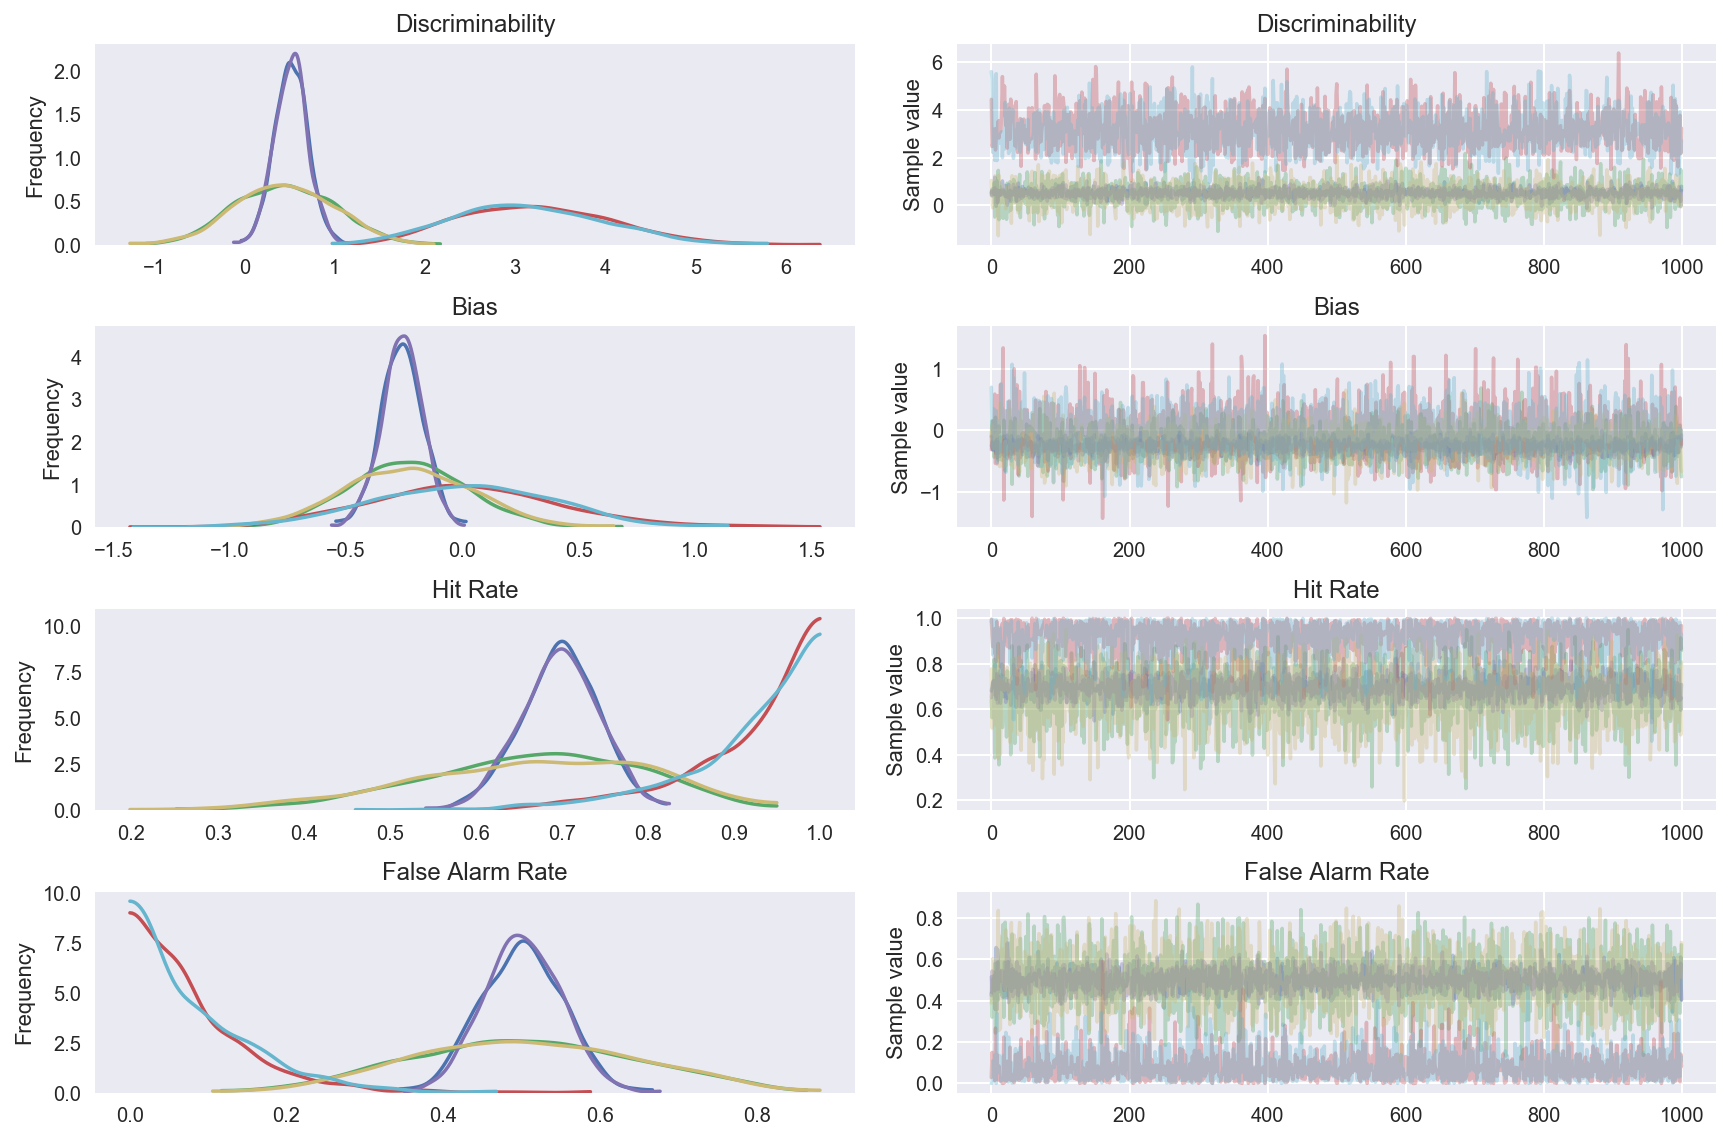

In [3]:
# Load data
dataset = 1
if dataset==1:  # Demo
    k = 3 # number of cases
    data =np.array([70, 50, 30, 50,
                    7,  5,  3,  5, 
                    10,  0,  0, 10]).reshape(k, -1)
else:  # Lehrner et al. (1995) data 
    k = 3 # number of cases
    data =np.array([148, 29, 32, 151,
                    150, 40, 30, 140,
                    150, 51, 40, 139]).reshape(k, -1)
    
h  = data[:, 0]
f  = data[:, 1]
MI = data[:, 2]
CR = data[:, 3]
s = h + MI
n = f + CR

def Phi(x):
    #'Cumulative distribution function for the standard normal distribution'
    # Also it is the probit transform 
    return 0.5 + 0.5 * pm.math.erf(x/pm.math.sqrt(2))
    
with pm.Model() as model1:
    di = pm.Normal('Discriminability', mu=0, tau=.5, shape= k)
    ci = pm.Normal('Bias', mu=0, tau=2, shape= k)
    
    thetah = pm.Deterministic('Hit Rate', Phi(di/2-ci))
    thetaf = pm.Deterministic('False Alarm Rate', Phi(-di/2-ci))
    
    hi = pm.Binomial('hi',p=thetah,n=s,observed=h)
    fi = pm.Binomial('fi',p=thetaf,n=n,observed=f)
    trace1=pm.sample(1000, tune=1000)

pm.traceplot(trace1, 
             varnames=['Discriminability', 'Bias', 'Hit Rate', 'False Alarm Rate']);

## 11.2 Hierarchical signal detection theory
  
$$ \mu_{d},\mu_{c} \sim \text{Gaussian}(0,.001)$$
$$ \lambda_{d},\lambda_{c} \sim \text{Gamma}(.001,.001)$$
$$ d_{i} \sim \text{Gaussian}(\mu_{d},\lambda_{d})$$
$$ c_{i} \sim \text{Gaussian}(\mu_{c},\lambda_{c})$$
$$ \theta_{i}^h = \Phi(\frac{1}{2}d_{i}-c_{i})$$
$$ \theta_{i}^f = \Phi(-\frac{1}{2}d_{i}-c_{i})$$
$$ h_{i} \sim \text{Binomial}(\theta_{i}^h,s_{i})$$
$$ f_{i} \sim \text{Binomial}(\theta_{i}^f,n_{i})$$

In [4]:
# Load data using rpy2
from rpy2 import *
%load_ext rpy2.ipython
%R source("data/heit_rotello.RData") -o std_i -o std_d 
# the induction data and the deduction data

h1  = np.array(std_i['V1'])
f1  = np.array(std_i['V2'])
MI1 = np.array(std_i['V3'])
CR1 = np.array(std_i['V4'])
s1 = h1 + MI1
n1 = f1 + CR1

h2  = np.array(std_d['V1'])
f2  = np.array(std_d['V2'])
MI2 = np.array(std_d['V3'])
CR2 = np.array(std_d['V4'])
s2 = h2 + MI2
n2 = f2 + CR2

k=len(h1)

In [5]:
with pm.Model() as model2i:
    mud = pm.Normal('mud', mu=0, tau=.001)
    muc = pm.Normal('muc', mu=0, tau=.001)
    lambdad = pm.Gamma('lambdad', alpha=.001, beta=.001)
    lambdac = pm.Gamma('lambdac', alpha=.001, beta=.001)
    
    di = pm.Normal('di', mu=mud, tau=lambdad, shape= k)
    ci = pm.Normal('ci', mu=muc, tau=lambdac, shape= k)

    thetah = pm.Deterministic('Hit Rate', Phi(di/2-ci))
    thetaf = pm.Deterministic('False Alarm Rate', Phi(-di/2-ci))

    hi = pm.Binomial('hi', p=thetah, n=s1, observed=h1)
    fi = pm.Binomial('fi', p=thetaf, n=n1, observed=f1)
    trace_i = pm.sample(1000, tune=1000, nuts_kwargs=dict(target_accept=.95))

with pm.Model() as model2d:
    mud = pm.Normal('mud', mu=0, tau=.001)
    muc = pm.Normal('muc', mu=0, tau=.001)
    lambdad = pm.Gamma('lambdad', alpha=.001, beta=.001)
    lambdac = pm.Gamma('lambdac', alpha=.001, beta=.001)
    
    di = pm.Normal('di', mu=mud, tau=lambdad, shape= k)
    ci = pm.Normal('ci', mu=muc, tau=lambdac, shape= k)
    
    thetah = pm.Deterministic('Hit Rate', Phi(di/2-ci))
    thetaf = pm.Deterministic('False Alarm Rate', Phi(-di/2-ci))

    hi = pm.Binomial('hi', p=thetah, n=s2, observed=h2)
    fi = pm.Binomial('fi', p=thetaf, n=n2, observed=f2)
    trace_d = pm.sample(1000, tune=1000, nuts_kwargs=dict(target_accept=.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ci, di, lambdac_log__, lambdad_log__, muc, mud]
100%|██████████| 2000/2000 [00:22<00:00, 89.87it/s] 
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8454248728127159, but should be close to 0.95. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ci, di, lambdac_log__, lambdad_log__, muc, mud]
100%|██████████| 2000/2000 [00:23<00:00, 86.70it/s] 
There were 47 divergences a

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


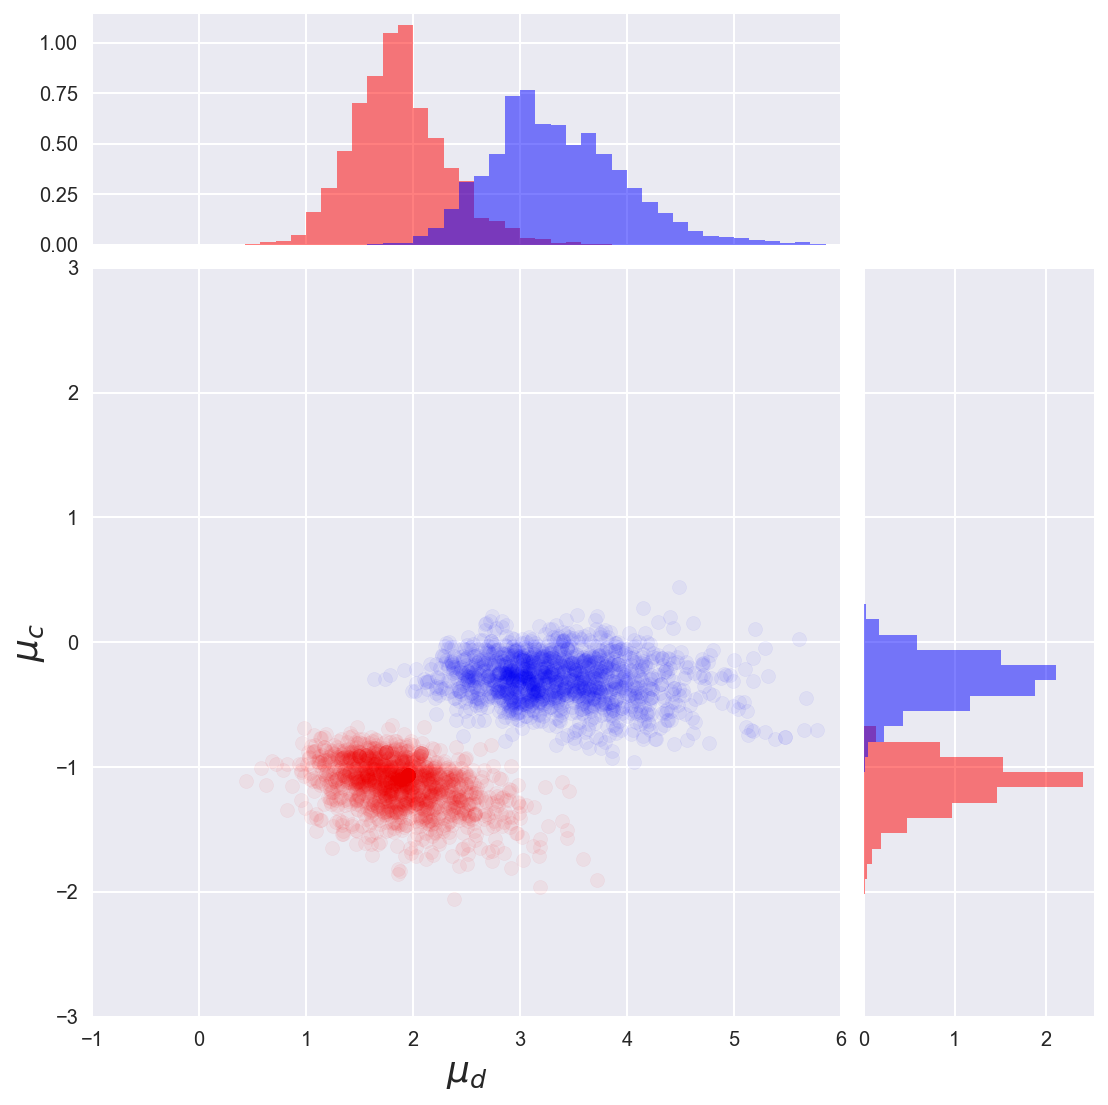

In [6]:
def scatterplot_2trace(trace1, trace2):
    from matplotlib.ticker import NullFormatter
    nullfmt = NullFormatter()         # no labels

    burnin=500 # set to zero to plot the one without burnin

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # now determine limits by hand:
    binwidth1 = 0.25

    # start with a rectangular Figure
    plt.figure(1, figsize=(8, 8))

    cc = np.array([[1,0,0],[0,0,1]])

    for idd in np.arange(2):
        if idd==0:
            x = trace1['mud'][burnin:]
            y = trace1['muc'][burnin:]
        else:
            x = trace2['mud'][burnin:]
            y = trace2['muc'][burnin:]

        axScatter = plt.axes(rect_scatter)
        axScatter.set_xlim((-1, 6))
        axScatter.set_ylim((-3, 3))

        axHistx = plt.axes(rect_histx)
        axHisty = plt.axes(rect_histy)

        # no labels
        axHistx.xaxis.set_major_formatter(nullfmt)
        axHisty.yaxis.set_major_formatter(nullfmt)

        # the scatter plot:
        axScatter.scatter(x, y,c=cc[idd,:],alpha=.05)
        axScatter.set_xlabel(r'$\mu_d$',fontsize=18)
        axScatter.set_ylabel(r'$\mu_c$',fontsize=18)

        bins1 = np.linspace(-1, 6, 50)
        axHistx.hist(x, bins=bins1,color=cc[idd,:],alpha=.5,normed=True)
        bins2 = np.linspace(-3, 3, 50)
        axHisty.hist(y, bins=bins2, color=cc[idd,:],alpha=.5,normed=True, orientation='horizontal')

        axHistx.set_xlim(axScatter.get_xlim())
        axHisty.set_ylim(axScatter.get_ylim())

    plt.show()

scatterplot_2trace(trace_i, trace_d)

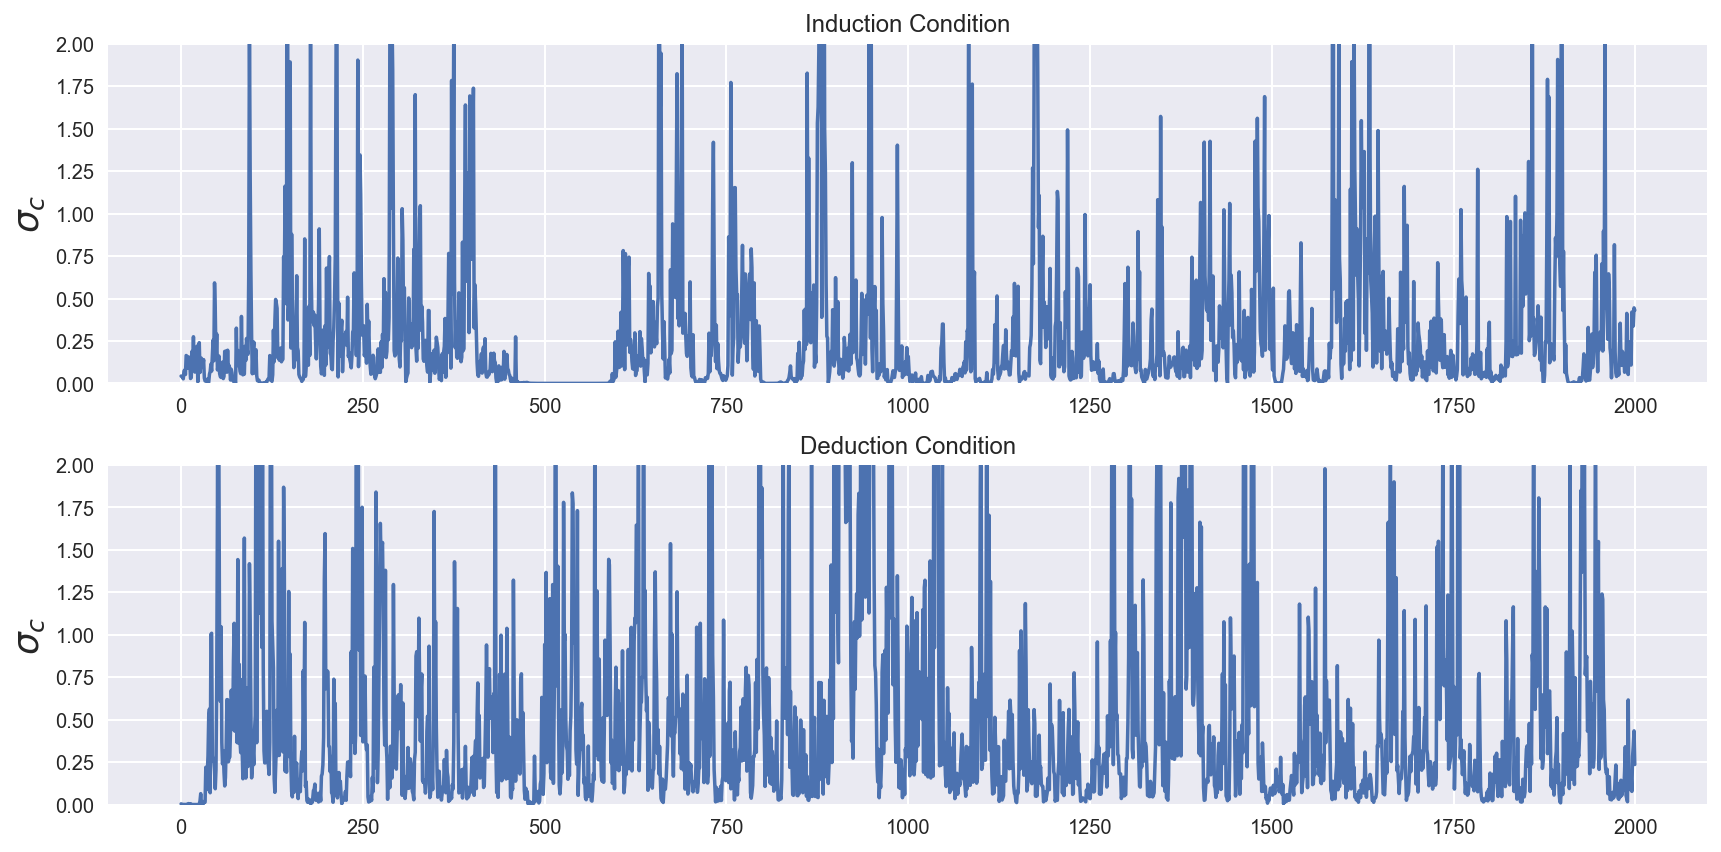

In [7]:
_, ax = plt.subplots(2, 1, figsize=(12, 6))
tmptrace = trace_i['lambdac']
ax[0].plot(1/tmptrace**2)
ax[0].set_ylim(0,2)
ax[0].set_title('Induction Condition')
ax[0].set_ylabel(r'$\sigma_c$',fontsize=18)

tmptrace = trace_d['lambdac']
ax[1].plot(1/tmptrace**2)
ax[1].set_ylim(0,2)
ax[1].set_title('Deduction Condition')
ax[1].set_ylabel(r'$\sigma_c$',fontsize=18)

plt.tight_layout();

## 11.3 Parameter expansion
  
  
Using parameter expansion to escape the "zero variance trap" in MCMC sampling.  

$$ \mu_{d},\mu_{c} \sim \text{Gaussian}(0,.001)$$
$$ \lambda_{d},\lambda_{c} \sim \text{Gamma}(.001,.001)$$
$$ \xi_{d},\xi_{c} \sim \text{Beta}(1,1)$$
$$ \delta_{d_{i}} \sim \text{Gaussian}(0,\lambda_{d})$$
$$ \delta_{c_{i}} \sim \text{Gaussian}(0,\lambda_{c})$$
$$ \sigma_{d} = \lvert \xi_{d}\rvert\,/\,\sqrt\lambda_{d}$$
$$ \sigma_{c} = \lvert \xi_{c}\rvert\,/\,\sqrt\lambda_{c}$$
$$ d_{i} = \mu_{d} + \xi_{d}\delta_{d_{i}}$$
$$ c_{i} = \mu_{c} + \xi_{c}\delta_{c_{i}}$$
$$ \theta_{i}^h = \Phi(\frac{1}{2}d_{i}-c_{i})$$
$$ \theta_{i}^f = \Phi(-\frac{1}{2}d_{i}-c_{i})$$
$$ h_{i} \sim \text{Binomial}(\theta_{i}^h,s_{i})$$
$$ f_{i} \sim \text{Binomial}(\theta_{i}^f,n_{i})$$

In [8]:
with pm.Model() as model3i:
    mud = pm.Normal('mud', mu=0, tau=.001)
    muc = pm.Normal('muc', mu=0, tau=.001)
    lambdad = pm.Gamma('lambdad', alpha=.001, beta=.001)
    lambdac = pm.Gamma('lambdac', alpha=.001, beta=.001)
    xid = pm.Uniform('xid', lower=0, upper=1)
    xic = pm.Uniform('xic', lower=0, upper=1)
    deltadi = pm.Normal('deltadi', mu=0, tau=lambdad, shape=k)
    deltaci = pm.Normal('deltaci', mu=0, tau=lambdac, shape=k)
    
    sigmad = pm.Deterministic('sigmad', xid/tt.sqrt(lambdad))
    sigmac = pm.Deterministic('sigmac', xic/tt.sqrt(lambdac))
    
    di = pm.Deterministic('di', mud+xid*deltadi)
    ci = pm.Deterministic('ci', muc+xic*deltaci)
    
    thetah = pm.Deterministic('Hit Rate', Phi(di/2-ci))
    thetaf = pm.Deterministic('False Alarm Rate', Phi(-di/2-ci))

    hi = pm.Binomial('hi', p=thetah, n=s1, observed=h1)
    fi = pm.Binomial('fi', p=thetaf, n=n1, observed=f1)
    trace_i2 = pm.sample(1000, tune=1000, nuts_kwargs=dict(target_accept=.95))

with pm.Model() as model3d:
    mud = pm.Normal('mud', mu=0, tau=.001)
    muc = pm.Normal('muc', mu=0, tau=.001)
    lambdad = pm.Gamma('lambdad', alpha=.001, beta=.001)
    lambdac = pm.Gamma('lambdac', alpha=.001, beta=.001)
    xid = pm.Uniform('xid', lower=0, upper=1)
    xic = pm.Uniform('xic', lower=0, upper=1)
    deltadi = pm.Normal('deltadi', mu=0, tau=lambdad, shape=k)
    deltaci = pm.Normal('deltaci', mu=0, tau=lambdac, shape=k)
    
    sigmad = pm.Deterministic('sigmad', xid/tt.sqrt(lambdad))
    sigmac = pm.Deterministic('sigmac', xic/tt.sqrt(lambdac))
    
    di = pm.Deterministic('di', mud+xid*deltadi)
    ci = pm.Deterministic('ci', muc+xic*deltaci)
    
    thetah = pm.Deterministic('Hit Rate', Phi(di/2-ci))
    thetaf = pm.Deterministic('False Alarm Rate', Phi(-di/2-ci))

    hi = pm.Binomial('hi', p=thetah, n=s2, observed=h2)
    fi = pm.Binomial('fi', p=thetaf, n=n2, observed=f2)
    trace_d2 = pm.sample(1000, tune=1000, nuts_kwargs=dict(target_accept=.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [deltaci, deltadi, xic_interval__, xid_interval__, lambdac_log__, lambdad_log__, muc, mud]
100%|██████████| 2000/2000 [01:13<00:00, 27.14it/s]
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8812760416818894, but should be close to 0.95. Try to increase the number of tuning steps.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8642111774004497, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [deltaci, deltadi, xic_interval__, xid_interval__,

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


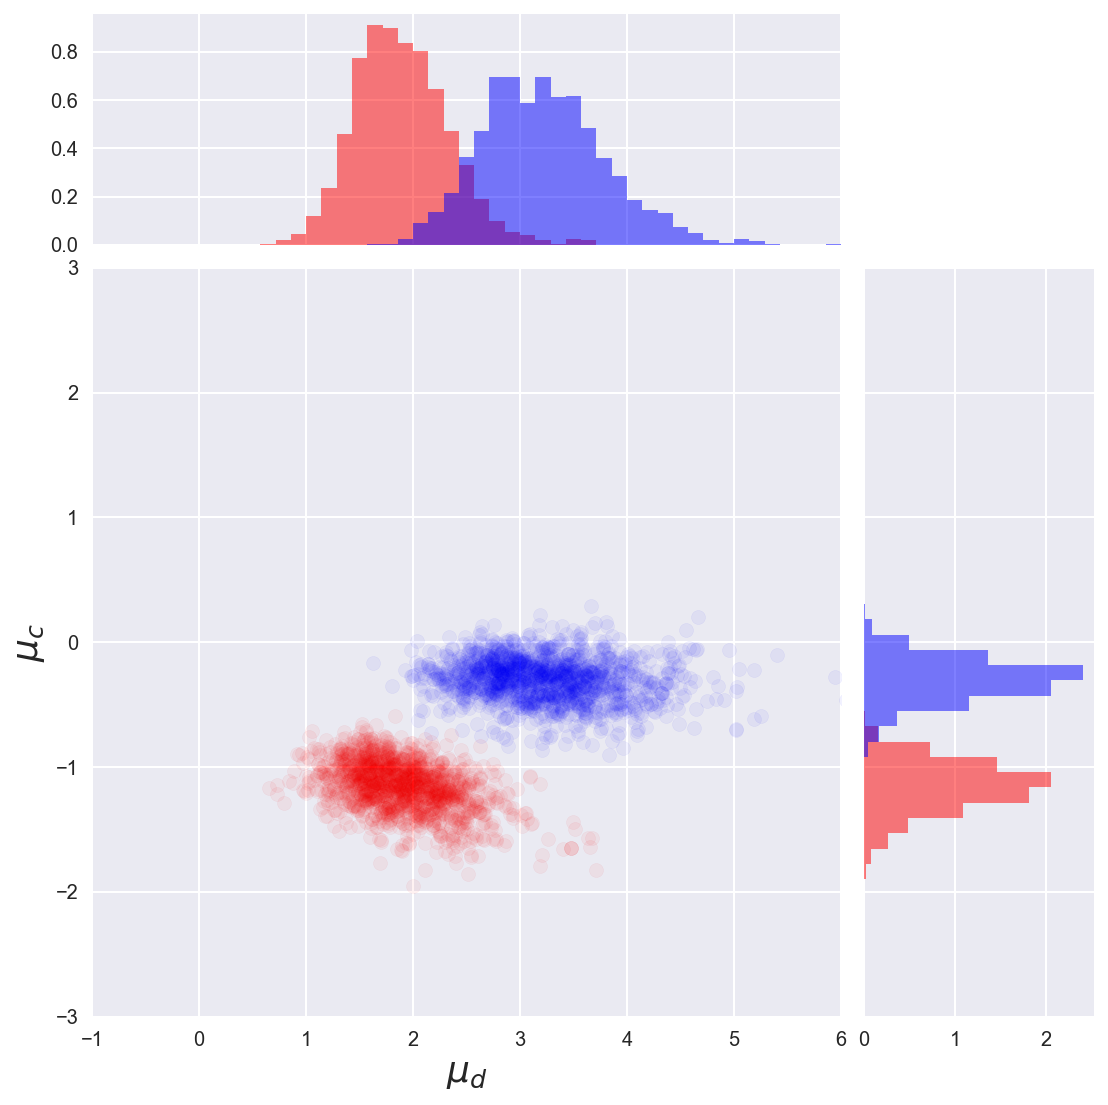

In [9]:
scatterplot_2trace(trace_i2, trace_d2)

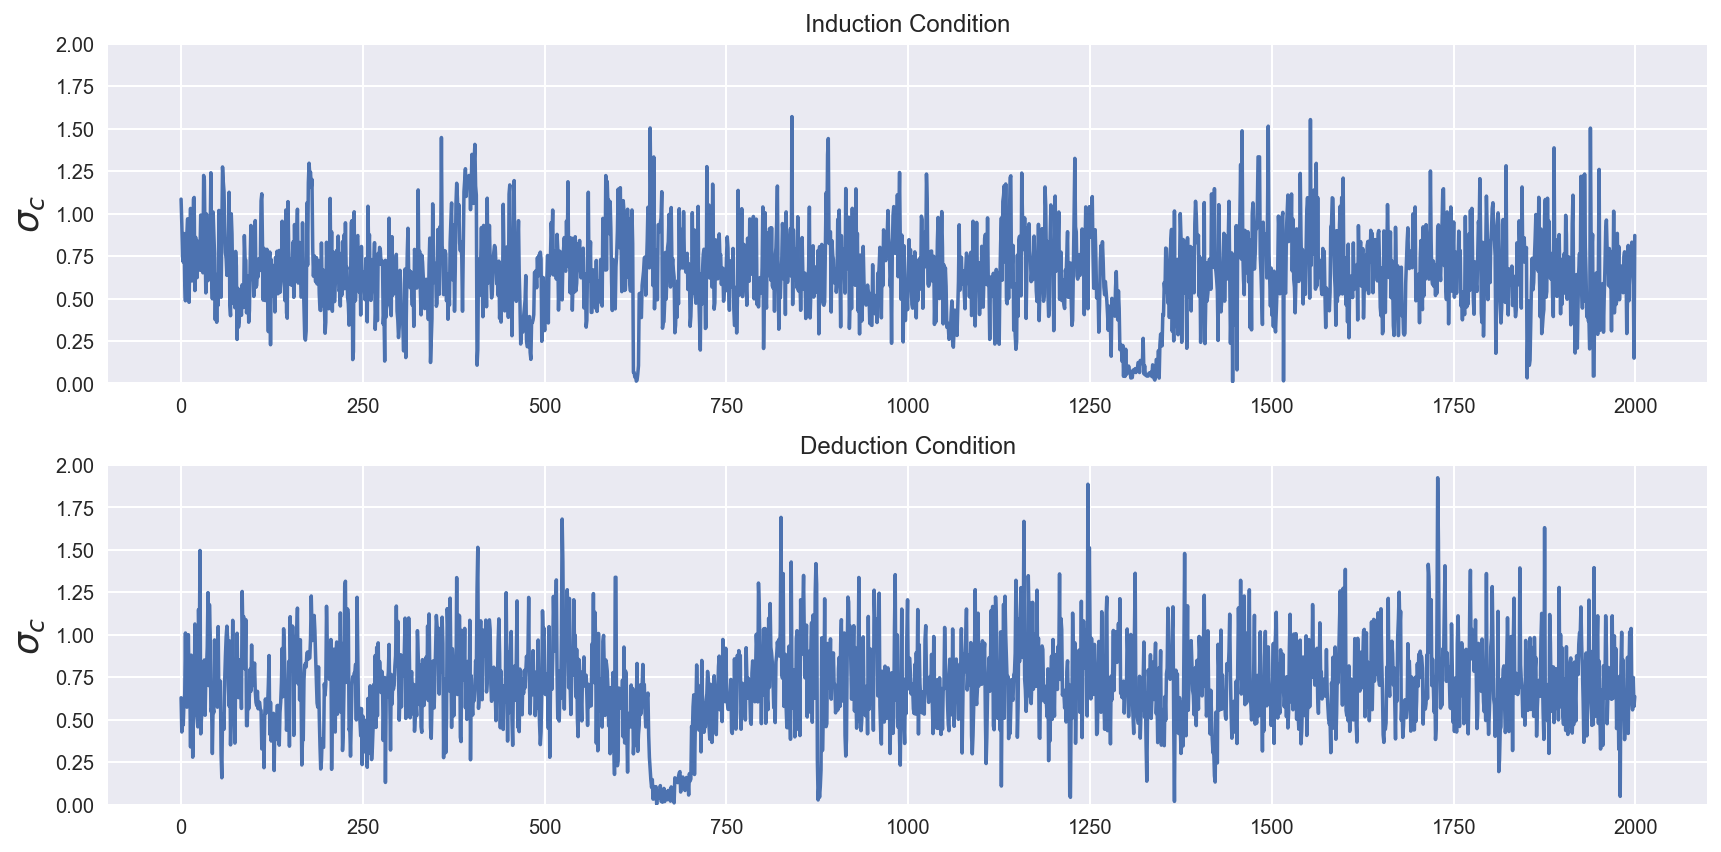

In [10]:
_, ax = plt.subplots(2, 1, figsize=(12, 6))
tmptrace = trace_i['lambdac']
ax[0].plot(trace_i2['sigmac'])
ax[0].set_ylim(0,2)
ax[0].set_title('Induction Condition')
ax[0].set_ylabel(r'$\sigma_c$',fontsize=18)

tmptrace = trace_d['lambdac']
ax[1].plot(trace_d2['sigmac'])
ax[1].set_ylim(0,2)
ax[1].set_title('Deduction Condition')
ax[1].set_ylabel(r'$\sigma_c$',fontsize=18)

plt.tight_layout();

### Note from Junpeng Lao
Sampling using HMC (e.g., in STAN and PyMC3), there are better way to diagnose biased inference [[1]](http://mc-stan.org/documentation/case-studies/divergences_and_bias.html), [[2]](http://pymc-devs.github.io/pymc3/notebooks/Diagnosing_biased_Inference_with_Divergences.html).

In [11]:
def plot_samplerstat(burnin, trace):
    # Sampler statistics
    accept = trace.get_sampler_stats('mean_tree_accept', burn=burnin)
    print('The accept rate is: %.5f' % (accept.mean()))
    diverge = trace.get_sampler_stats('diverging')
    print('Diverge of the trace')
    print(diverge.nonzero())
    energy = trace['energy']
    energy_diff = np.diff(energy)
    sns.distplot(energy - energy.mean(), label='energy')
    sns.distplot(energy_diff, label='energy diff')
    plt.legend()
    plt.show()

The accept rate is: 0.89861
Diverge of the trace
(array([  57,  174,  223,  224,  225,  226,  228,  229,  393,  399,  487,
        488,  491,  493,  495,  498,  499,  501,  503,  504,  505,  509,
        510,  512,  517,  518,  523,  524,  525,  526,  527,  529,  530,
        531,  533,  534,  538,  539,  541,  544,  545,  548,  549,  550,
        558,  573,  585,  689,  756,  762, 1176, 1591, 1847]),)


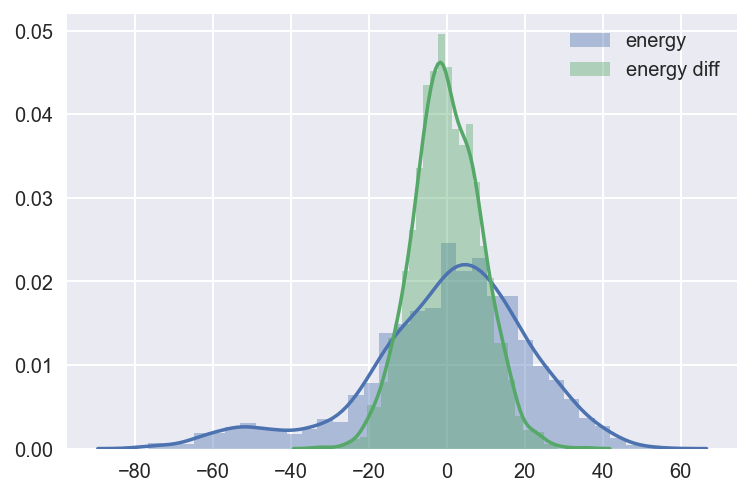

In [12]:
plot_samplerstat(0, trace_i)

The accept rate is: 0.95081
Diverge of the trace
(array([ 275,  276,  346,  349,  350,  353,  354,  356,  416,  418,  513,
        516,  584,  585,  626,  627,  629,  630,  632,  633,  635,  799,
        906,  907,  908,  909,  910,  911,  912,  913,  914,  915,  916,
        917,  919,  927,  928,  929,  931,  933,  934,  936,  937,  948,
        949,  950,  978, 1039, 1055, 1071, 1100, 1102, 1122, 1139, 1141,
       1158, 1270, 1271, 1344, 1385, 1445, 1463, 1473, 1474, 1662, 1732,
       1756, 1934, 1940]),)


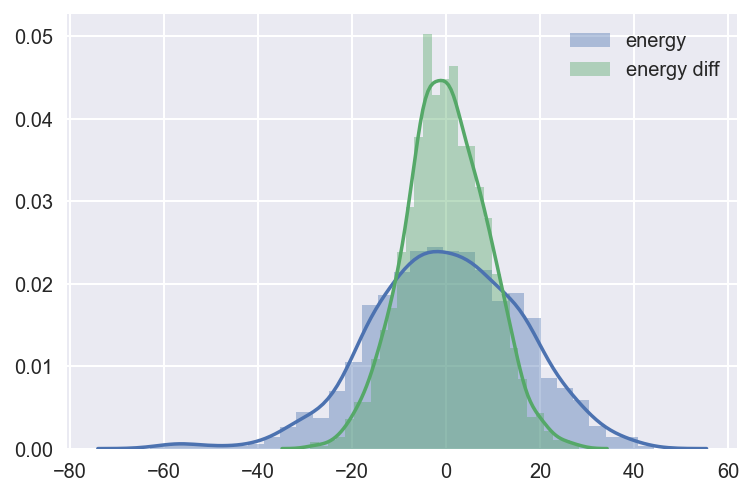

In [13]:
plot_samplerstat(0, trace_d)

The accept rate is: 0.87274
Diverge of the trace
(array([  16,  176,  178,  333,  350,  357,  358,  360,  372,  381,  383,
        389,  390,  391,  392,  393,  394,  395,  396,  397,  398,  399,
        400,  403,  404,  422,  508,  585,  586,  606,  648,  658,  659,
        660,  661,  691,  722,  724,  738,  748,  804,  888,  890,  911,
        932,  946,  980, 1203, 1230, 1248, 1250, 1255, 1370, 1411, 1437,
       1450, 1456, 1458, 1459, 1460, 1473, 1479, 1481, 1482, 1483, 1486,
       1491, 1597, 1641, 1642, 1643, 1682, 1768, 1793, 1794, 1804, 1805,
       1806, 1823, 1868, 1899, 1922, 1934, 1943, 1944, 1952, 1956, 1958,
       1959, 1963, 1964, 1965, 1969, 1972, 1973, 1975, 1983, 1984, 1986,
       1993, 1996, 1997]),)


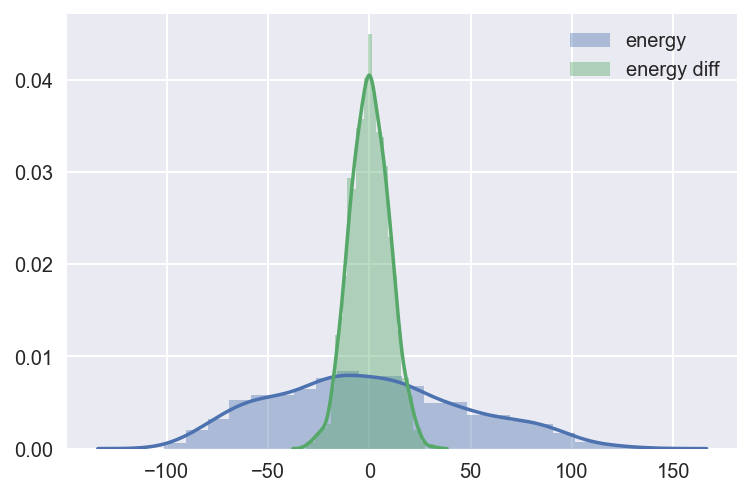

In [14]:
plot_samplerstat(0, trace_i2)

The accept rate is: 0.88795
Diverge of the trace
(array([  25,   32,   33,   35,   70,   87,  159,  160,  161,  162,  169,
        171,  172,  173,  174,  175,  176,  177,  179,  180,  181,  183,
        184,  185,  186,  205,  206,  209,  212,  214,  216,  224,  228,
        232,  233,  234,  244,  245,  265,  267,  269,  273,  274,  317,
        344,  352,  353,  355,  356,  357,  360,  369,  371,  380,  387,
        388,  389,  391,  399,  403,  404,  405,  412,  413,  416,  417,
        418,  420,  421,  422,  424,  427,  435,  458,  465,  466,  470,
        471,  474,  475,  476,  477,  478,  479,  486,  487,  492,  494,
        497,  509,  512,  513,  514,  522,  524,  525,  526,  527,  532,
        535,  537,  538,  540,  561,  572,  575,  581,  582,  585,  592,
        594,  597,  598,  599,  607,  663,  740,  742,  751,  788,  790,
        791,  792,  797,  798,  801,  802,  807,  809,  810,  811,  812,
        818,  821,  822,  823,  828,  840,  847,  849,  850,  907,  913,
 

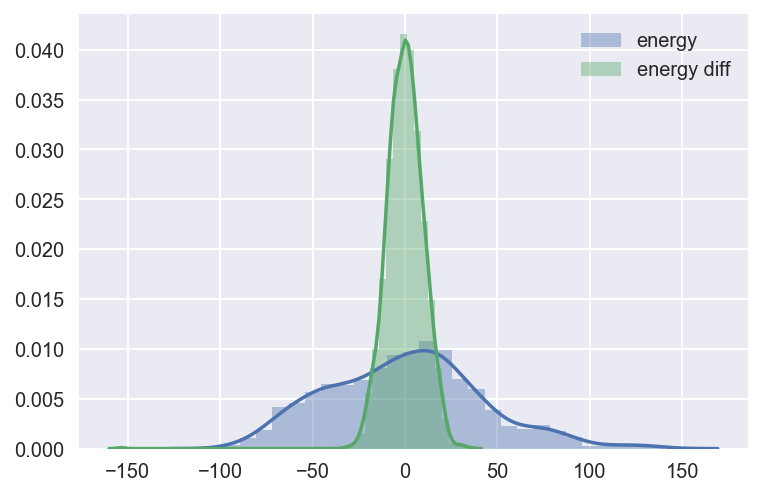

In [15]:
plot_samplerstat(0, trace_d2)

As shown above, there are a lot of divergences in the trace, and the energy plot is very different from the energy_diff. This is a strong indication of bias in the estimation, and better reparameterization is needed.

Moreover, the reparameterization, which works better in BUGS/JAGS using Gibbs sampler, actually perform worse using NUTS. Again, this demonstrates that many of the tricks and intuition we got using BUGS/JAGS might not translate to PyMC3 and STAN.